# Planning a telescope observation (Markov Chains)


Let's suppose we are astronomers and are planning an expensive observational campaign. We want to know how likely it is that tomorrow night will be clear given the weather tonight (clear or cloudy). The key piece of information here is that the weather tomorrow depends on the weather today. From past history, you know that:

$$p({\rm clear \; tomorrow} \, |\,  {\rm cloudy \; today}) = 0.5,$$

which means that

$$p({\rm cloudy \; tomorrow} \, |\, {\rm cloudy \; today}) = 0.5.$$

We also have

$$p({\rm cloudy \; tomorrow} \, |\, {\rm clear \; today}) = 0.1,$$

which means that

$$p({\rm clear \; tomorrow} \, |\, {\rm clear \; today}) = 0.9.$$


- We can start with the sky conditions today and make predictions going forward more and more into the future.
- This will look like a big decision tree. 
- After enough days, we'll reach equilibrium probabilities that have to do with the mean weather statistics (ignoring seasons) and we'll arrive at

$$p({\rm clear}) = 0.83,$$

and 

$$p({\rm cloudy}) = 0.17.$$

You get the same answer for day $N$ as day $N+1$ and it doesn't matter whether it was clear or cloudy on the day that you started. The steps that we have taken in this process are a **MARKOV CHAIN**.

#### Tasks

- Start off on a cloud day. 
- Implement your weather forecast based on the above probabilities
- Run your simulator for N days (with $N\gtrsim 10^4$)
- Prepare a plot with the number of days on the x axis and the "running average" on the y axis (that is, the cumulative number of, say, sunny days over the number of days so far). This is called a **trace-plot**, showing how our estimate of $p(\mathrm{clear})$ evolves as the chain samples.  
- Prepare a histogram of the above plot. This reveals the distribution of $p(\mathrm{clear})$. - Use a summary statistics to determine the most likely value and an error on our estimate.

**Important:** 
- In MCMC the process must be **stationary** which basically means that the chain statistics look the same no matter which chunk you look at, e.g. first half, second half, or every other point, etc.  
- Obviously that isn't going to be the case in the early steps of the chain. In our example above, after some time the process was stationary, but not in the first few days.
- So, there is a **burn-in** phase that needs to be discarded. How one determines the number of early steps to discard as burn-in is tricky, but ***you should always start with a traceplot of your samples!!!***


#### Tasks

- In the above example, experiment with chopping off different numbers of initial points as burn-in.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

N_days = 50000 #number of days

# sunny = 1, cloudy = 0
day = np.zeros([5, N_days]) #let's try with 5 different chains

day[:,0] = 0

np.random.seed(3)
#building the chain
for j in range(5):
    for i in range(N_days-1):
        if day[j,i] == 0:
            day[j,i+1] = np.random.choice([0, 1], p=[0.5, 0.5])
    
        if day[j,i] == 1:
            day[j,i+1] = np.random.choice([0, 1], p=[0.1, 0.9])


Text(0.5, 1.0, 'Trace plot')

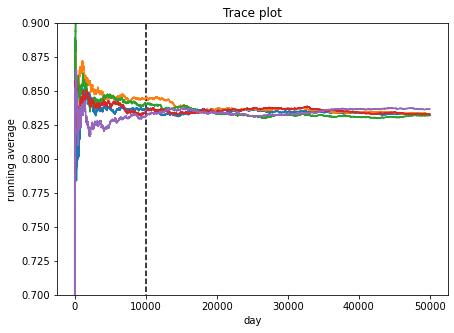

In [2]:
sunny_mean = np.zeros([5, N_days]) #cumulative number of sunny days over N_days

fig, ax = plt.subplots(1,1, figsize=(7,5))

for j in range(5):
    for i in range(N_days):
        sunny_mean[j,i] = np.sum(day[j,:i+1])/(i+1)
    ax.plot(np.linspace(0, N_days, N_days), sunny_mean[j])

ax.vlines(x=10000, ymin=0, ymax=1, ls='--')
ax.set_ylim([0.7, 0.9])
ax.set_xlabel('day')
ax.set_ylabel('running average')
ax.set_title('Trace plot')

Here I have created multiple chains to highlight the differences in the burn-in phase, where all the chains are displaying very different values.

Let's try to see how the distribution of samples inside one chain changes as the burn-in phase gets bigger.

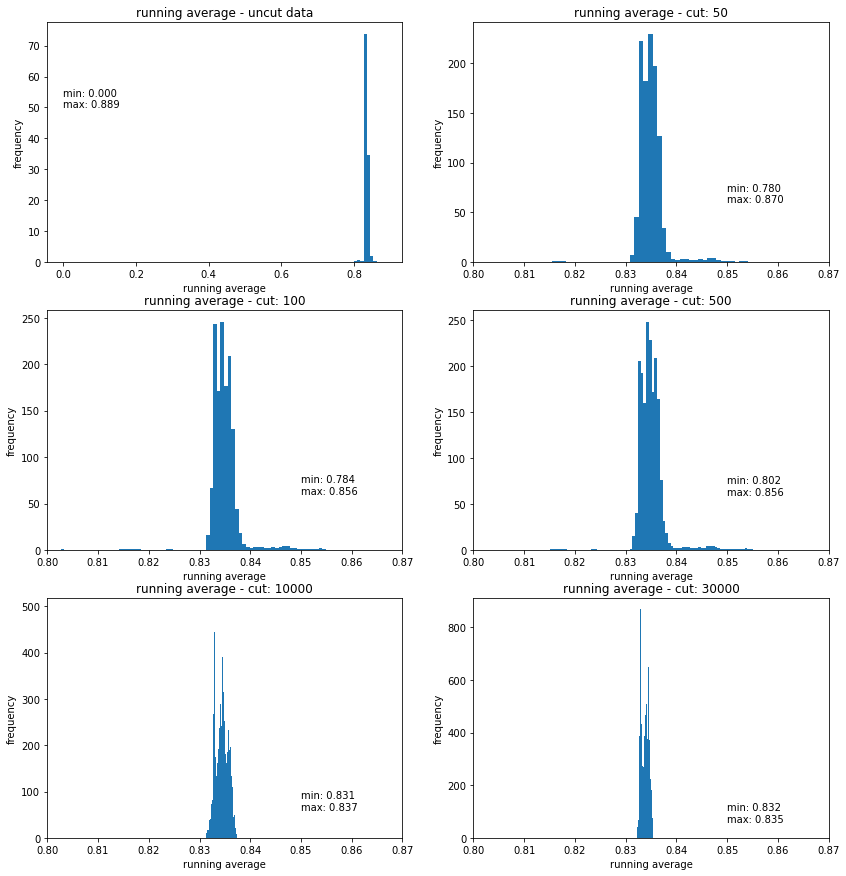

In [8]:
fig, ax = plt.subplots(3,2, figsize=(14,15))
ax=ax.reshape(-1)
ax[0].hist(sunny_mean[0], bins=100, density=True)
ax[0].text(0.0, 50, 'min: %.3f \nmax: %.3f' %(np.min(sunny_mean[0]), np.max(sunny_mean[0])) )

#selecting the first chain and try different burn-in cuts
sunny_mean_cut = [sunny_mean[0, 50:]]
sunny_mean_cut.append(sunny_mean[0, 100:])
sunny_mean_cut.append(sunny_mean[0, 500:])
sunny_mean_cut.append(sunny_mean[0, 10000:])
sunny_mean_cut.append(sunny_mean[0, 30000:])

for i in range(1,6):
    ax[i].hist(sunny_mean_cut[i-1], bins=100, density=True)
    ax[i].set_xlim(0.8, 0.87)
    ax[i].set_title('running average - cut: %.0f' %(len(sunny_mean[0])-len(sunny_mean_cut[i-1])))
    ax[i].text(0.85, 60, 'min: %.3f \nmax: %.3f' %(np.min(sunny_mean_cut[i-1]), np.max(sunny_mean_cut[i-1])))

ax[0].set_title('running average - uncut data')

for i in ax:
    i.set_ylabel('frequency')
    i.set_xlabel('running average')

It's easy to notice how cutting the chain deeper means cutting the outliers off, it's a sign that most of the variations to the chain are happening in the first burn-in part. Cutting the chain with a burn-in phase of 10000 I think could be a good choice in order not to have too many outliers but at the same time it allows to have a good amount of points to find reliable estimators. Let's look at some estimators to describe the distribution.

In [4]:
#mean of the first chain cut at 10000
print('the mean is : %.4f' %np.mean(sunny_mean_cut[3]))

the mean is : 0.8344


In [5]:
#median of the first chain cut at 10000
print('the median is: %.4f' %np.median(sunny_mean_cut[3]))

the median is: 0.8344


The median and the mean are very similar, probably the distribution is going to be symmetric.

In [6]:
from astroML.stats import sigmaG
unc = sigmaG(sunny_mean_cut[3])
print('sigmaG is %.4f' %unc)                                                                                                        

sigmaG is 0.0016


0.832812561509844 0.836014470868028


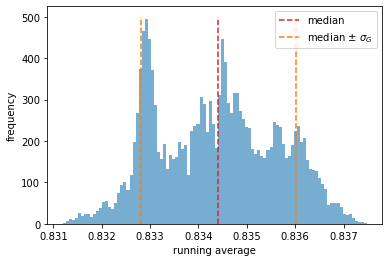

In [7]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

ax.hist(sunny_mean_cut[3], bins=100, alpha=0.6, density=True)
ax.vlines(np.median(sunny_mean_cut[3]), ymin=0, ymax=500, linestyle='--', color='tab:red', label='median')
ax.vlines(np.median(sunny_mean_cut[3])-unc, ymin=0, ymax=500, linestyle='--', color='tab:orange', label='median $\pm$ $\sigma_{G}$')
ax.vlines(np.median(sunny_mean_cut[3])+unc, ymin=0, ymax=500, linestyle='--', color='tab:orange')

ax.set_xlabel('running average')
ax.set_ylabel('frequency')
ax.legend()

print(np.median(sunny_mean_cut[3])-unc, np.median(sunny_mean_cut[3])+unc)

Since the distribution is not a Gaussian or a symmetric one, I used the median as an estimator for the true value of the probability $p$(clear), and I used the $\sigma_G$ as an estimator for the spread of the distribution. The results are showing that it's very probable to find $p$(clear) in the interval between 0.833-0.836, which is alligned with the actual value of 0.83.